# **Final Project**

For our final project we try to forecast stock price on a given day from a sequence of previous days data.

We will try several models, starting from a simple LSTM adapted from our Lab 2 work.  With some modifications:

* Removing the last linear layer activation function as we are going to do a forecast and not a classification.

* Reshaping the output dimensions so that we can predict as many features as we like.

* Changing the loss function into a MSE lost. In order to project the diference between the predicted price and the actual next day closing price


In [ ]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.modules import activation
import torch
from torch import nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

In [ ]:
drive.mount('/content/drive')
myDrive = '/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/Mixed_ETF/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = os.path.join(myDrive,'ETF_Data.csv')
data = pd.read_csv(file_path, sep=",", header=0)

Shape of the data

In [ ]:
data.head()

,Date_vaw,Open_vaw,High_vaw,Low_vaw,Close_vaw,Volume_vaw,Open_vcr,High_vcr,Low_vcr,Close_vcr,...,Open_vht,High_vht,Low_vht,Close_vht,Volume_vht,Open_vnq,High_vnq,Low_vnq,Close_vnq,Volume_vnq
0,2005-02-25,54.737,55.614,54.737,55.594,20156,49.021,49.292,49.021,49.255,...,46.707,47.021,46.602,47.021,122102,39.719,40.308,39.719,40.272,39871
1,2005-02-28,55.728,55.728,54.855,55.194,47699,49.274,49.274,49.021,49.183,...,46.800,46.800,46.207,46.476,13375,40.301,40.401,39.749,40.156,72024
2,2005-03-01,55.418,55.640,55.041,55.130,17578,49.403,49.653,49.403,49.653,...,46.622,46.791,46.622,46.753,46598,40.079,40.577,40.079,40.577,45622
3,2005-03-02,54.649,55.263,54.649,55.085,11532,49.589,49.969,49.589,49.784,...,46.587,47.049,46.587,46.791,160287,40.308,40.499,40.207,40.308,20521
4,2005-03-03,55.409,55.409,54.855,55.122,28440,49.822,49.822,49.543,49.755,...,46.883,46.910,46.641,46.724,29446,40.308,40.569,40.224,40.522,12941


In [ ]:
# Assign the "Date_vaw" column as the dataset index
data.rename(columns={'Date_vaw': 'Date'}, inplace=True)
data.index = pd.to_datetime(data['Date'])
data.pop('Date')
#Split into Train(70%) Validation(10%) and Test(20%)
Train = data[:2240]
Validation = data[2240:2560]
Test = data[2560:]
print(Train.shape)
print(Test.shape)
print(Validation.shape)

(2240, 35)
(641, 35)
(320, 35)


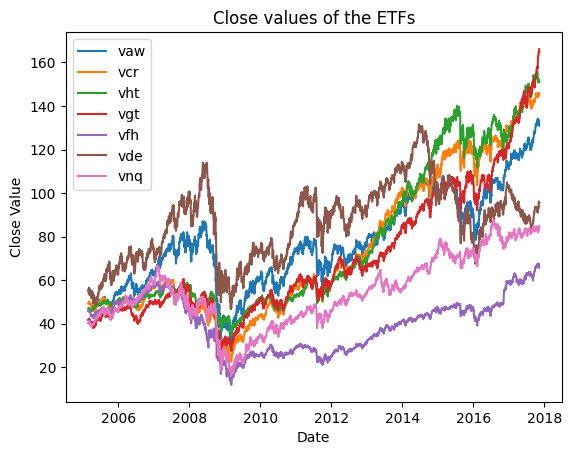

In [ ]:
#Plot all 7 ETFs
plt.plot(data.index, data['Close_vaw'], label='vaw')
plt.plot(data.index, data['Close_vcr'], label='vcr')
plt.plot(data.index, data['Close_vht'], label='vht')
plt.plot(data.index, data['Close_vgt'], label='vgt')
plt.plot(data.index, data['Close_vfh'], label='vfh')
plt.plot(data.index, data['Close_vde'], label='vde')
plt.plot(data.index, data['Close_vnq'], label='vnq')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Close values of the ETFs')
plt.legend()
plt.show()

In [ ]:

# Compute mean and std of the training set
mean = np.mean(Train, axis=(0))
std = np.std(Train, axis=(0))
std[std == 0] = 1

# Normalize training data
Train_normalized = (Train - mean) / std

# Normalize validation data
Validation_normalized = (Validation - mean) / std

# Normalize test data
Test_normalized = (Test - mean) / std

 # Sequence extraction

 From the data of all the days we create our sequences that we will input to the model aswell as creating the real closing price labels.

 we split the dataset into fragments of fragment_size (10) with the inputed step (1).

Train_Fragmented makes fragment from day [1 to 10], [2 to 11], ...
Train_Labels takes close variable from the days after each fragment from Train_fragmented.

We have also tested different steps but a step of one worked vest even on validation and test data

In [ ]:
multi_stock = False  #if false only use selected ETF_active  else: use all
multi_column = False  #if false only use closing price else: open,high,low,close,volume

ETF = ['vaw', 'vcr', 'vgt', 'vfh', 'vde', ' vht', 'vnq']
if(not multi_stock):
  ETF_active = ETF[3]

fragment_size = 10    #number of days in each fragment
step = 1    #days of separation between fragments


if (multi_column):
  if (multi_stock):
    Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size] for i in range(0, len(Train_normalized) - fragment_size, step)]
    Train_Labels = [Train_normalized.iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Train_normalized), step)]

    Validation_Fragmented = [Validation_normalized .iloc[i:i + fragment_size] for i in range(0, len(Validation_normalized ) - fragment_size, step)]
    Validation_Labels = [Validation_normalized .iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Validation_normalized ), step)]

    Test_Fragmented = [Test_normalized .iloc[i:i + fragment_size] for i in range(0, len(Test_normalized ) - fragment_size, step)]
    Test_Labels = [Test_normalized .iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Test_normalized ), step)]
  else:
    Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Train_normalized) - fragment_size, step)]
    Train_Labels = [Train_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Train_normalized), step)]

    Validation_Fragmented = [Validation_normalized.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Validation_normalized) - fragment_size, step)]
    Validation_Labels = [Validation_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Validation_normalized), step)]

    Test_Fragmented = [Test_normalized.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Test_normalized ) - fragment_size, step)]
    Test_Labels = [Test_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Test_normalized ), step)]
else:
  if (multi_stock):
    Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(0, len(Train_normalized) - fragment_size, step)]
    Train_Labels = [Train_normalized.iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Train_normalized), step)]

    Validation_Fragmented = [Validation_normalized.iloc[i:i + fragment_size][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(0, len(Validation_normalized) - fragment_size, step)]
    Validation_Labels = [Validation_normalized.iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Validation_normalized), step)]

    Test_Fragmented = [Test_normalized .iloc[i:i + fragment_size][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(0, len(Test_normalized ) - fragment_size, step)]
    Test_Labels = [Test_normalized .iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Test_normalized ), step)]
  else:
    Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Close_'  + ETF_active]] for i in range(0, len(Train_normalized) - fragment_size, step)]
    Train_Labels = [Train_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Train_normalized), step)]

    Validation_Fragmented = [Validation_normalized.iloc[i:i + fragment_size][['Close_'  + ETF_active]] for i in range(0, len(Validation_normalized) - fragment_size, step)]
    Validation_Labels = [Validation_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Validation_normalized), step)]

    Test_Fragmented = [Test_normalized.iloc[i:i + fragment_size][['Close_'  + ETF_active]] for i in range(0, len(Test_normalized ) - fragment_size, step)]
    Test_Labels = [Test_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Test_normalized ), step)]


In [ ]:
# Print dimensions for verification
print(f'Number of Train Fragments: {len(Train_Fragmented)}')
print(f'Number of Train Labels: {len(Train_Labels)}')
print(f'Number of Validation Fragments: {len(Validation_Fragmented)}')
print(f'Number of Validation Labels: {len(Validation_Labels)}')
print(f'Number of Test Fragments: {len(Test_Fragmented)}')
print(f'Number of Test Labels: {len(Test_Labels)}')


Number of Train Fragments: 2230
Number of Train Labels: 2230
Number of Validation Fragments: 310
Number of Validation Labels: 310
Number of Test Fragments: 631
Number of Test Labels: 631


# pytorch and cuda

In [ ]:
#Transform the data into tensor format
tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Fragmented]
X_train = torch.stack(tensor_list)
label_tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Labels]
Y_train =  torch.stack(label_tensor_list)

tensor_list_validation = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Validation_Fragmented]
X_Validation = torch.stack(tensor_list_validation)
label_tensor_list_validation = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Validation_Labels]
Y_Validation =  torch.stack(label_tensor_list_validation)

tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Fragmented]
X_test = torch.stack(tensor_list_test)
label_tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Labels]
Y_test =  torch.stack(label_tensor_list_test)

In [ ]:
#Load the data into cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming X_train, Y_train, X_test, Y_test are already defined and normalized
X_train_pt = X_train.float().to(device)
Y_train_pt = Y_train.float().to(device)
X_Validation_pt = X_Validation.float().to(device)
Y_Validation_pt = Y_Validation.float().to(device)
X_test_pt = X_test.float().to(device)
Y_test_pt = Y_test.float().to(device)
#Data loader, provides batches of 32 sequences shuffled
train_dataset = torch.utils.data.TensorDataset(X_train_pt, Y_train_pt)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


#Models

In [ ]:
class Simple_LSTM(nn.Module):
    def __init__(self,
                 input_size: int = 5,
                 hidden_size: int = 64,
                 output_size: int = 1,
                 num_layers: int = 5,
                 dropout_prob: float = 0.05
                 ):
        super().__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)

        self.dropout = nn.Dropout(p=dropout_prob)

        self.last_linear = nn.Linear(hidden_size, output_size)


        #self.batchnorm = nn.BatchNorm1d(hidden_size)   gave us some issues on our data so we didn't use it.
    def forward(self, X):
        _, last_states = self.lstm(X)
        last_hidden_state = last_states[0][-1, :, :]
        last_hidden_state = self.dropout(last_hidden_state) #most of the time we set the prov of dropout to 0

        next_prediction = self.last_linear(last_hidden_state)
        return next_prediction


In [ ]:
class Conv_LSTM(nn.Module):
    def __init__(self,
                 conv_filters: int=128,
                 conv_kernel_size: int=1,
                 input_size: int=35,
                 hidden_size: int=64,
                 output_size: int=7,
                 dropout_prob: int =0.05,
                 num_layers: int=1
                ):
        super(Conv_LSTM, self).__init__()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.conv = nn.Conv1d(in_channels=input_size, out_channels=conv_filters, kernel_size=conv_kernel_size, stride=1, padding='same')
        self.lstm = nn.LSTM(input_size=conv_filters, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.last_linear = nn.Linear(hidden_size, output_size)
        self.avgpool = nn.AvgPool1d(1)  #we saw it on a paper but we think it doen't do much
        self.dropout = nn.Dropout(p=dropout_prob)
        self.batchnorm = nn.BatchNorm1d(hidden_size)

    def forward(self, X):
        x = self.conv(X.permute(0, 2, 1))  # Permute to [batch_size, num_features, sequence_length]
        x = self.tanh(x)
        x = self.avgpool(x)
        x = self.relu(x)
        _, (x, _) = self.lstm(x.permute(0, 2, 1))
        x = x[-1, :, :]
        x = self.dropout(x)  # Add dropout
        x = self.last_linear(x)
        return x
#architecture inspired by : https://doi.org/10.1155/2020/6622927

In [ ]:
def train_and_validation_loop(model, loss_func, optimizer, train_loader, X_Validation, Y_Validation ,num_epochs = 100):
  loss_its = []

  for epoch in range(num_epochs):
      model.train() #model in train mode
      epoch_loss = 0.0
      for batch_X, batch_Y in train_loader: #batch iteration from data_loader
          optimizer.zero_grad()

          batch_X = batch_X.to(device)         # Move batch data to the device
          batch_Y = batch_Y.to(device)

          # Forward
          output = model(batch_X)

          # Compute loss
          loss = loss_func(output, batch_Y)
          epoch_loss += loss.item()

          #backpropagation
          loss.backward()
          optimizer.step()

      epoch_loss /= len(train_loader)       # Compute average loss for the epoch
      loss_its.append(epoch_loss)

      if epoch % 5 == 0: #print loss after 5 epochs
          output_test = model(X_test_pt)
          test_loss = loss_func(output_test, Y_test_pt) #test loss to see if there is overfit on training
          print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss},Test_loss: {test_loss}')

  print(f'Epoch [{num_epochs}], Loss: {epoch_loss},Test_loss: {test_loss}')
  print('Training complete.')

  model.eval()
  with torch.no_grad():
    output = model(X_Validation)
    val_loss = loss_func(output,Y_Validation)
  print(val_loss)
  return val_loss.item()




In [ ]:
cnn = False #flag to use cnn or not

In [ ]:
# combination of parameters to try on validation
if (multi_column):
  if (multi_stock):
    if(cnn):
      param_grid = {
        'input_size': [35],
        'hidden_size': [20, 50],
        'output_size': [7],
        'num_layers': [1, 3, 5],
        'dropout': [0.0],
        'conv_kernel_size':[1,3,5],
        'conv_filters' : [64,128]
        }
      num_epoch = 50
    else:
      param_grid = {
        'input_size': [35],
        'hidden_size': [20, 50],
        'output_size': [7],
        'num_layers': [1, 3, 5],
        'dropout': [0.0]
        }
      num_epoch = 50
  else:
    if(cnn):
      param_grid = {
        'input_size': [5],
        'hidden_size': [20, 50, 200, 1000],
        'output_size': [1],
        'num_layers': [1,4],
        'dropout': [0.0],
        'conv_kernel_size':[1,4],
        'conv_filters' : [64,128]
        }
      num_epoch = 50
    else:
      param_grid = {
        'input_size': [5],
        'hidden_size': [20, 50],
        'output_size': [1],
        'num_layers': [1, 3, 5],
        'dropout': [0.0]
    }
      num_epoch = 50
else:
  if (multi_stock):
    if(cnn):
      param_grid = {
        'input_size': [7],
        'hidden_size': [20, 50],
        'output_size': [7],
        'num_layers': [1, 3, 5],
        'dropout': [0.0],
        'conv_kernel_size':[1,3,5],
        'conv_filters' : [64,128]
        }
      num_epoch = 50
    else:
      param_grid = {
        'input_size': [7],
        'hidden_size': [20, 50],
        'output_size': [7],
        'num_layers': [1, 3, 5],
        'dropout': [0.0]
    }
      num_epoch = 50
  else:
    if(cnn):
      param_grid = {
          'input_size': [1],
          'hidden_size': [20, 50],
          'output_size': [1],
          'num_layers': [1, 3, 5],
          'dropout': [0.0],
          'conv_kernel_size':[1,3,5],
          'conv_filters' : [64,128]
          }
      num_epoch = 50
    else:
      param_grid = {
        'input_size': [1],
        'hidden_size': [20, 50],
        'output_size': [1],
        'num_layers': [1, 3, 5],
        'dropout': [0.0]
    }
      num_epoch = 50



loss_func = nn.MSELoss() #Loss function

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) tried a different optimizer but did not improve

best_params = None
best_val_loss = float('inf')
for params in ParameterGrid(param_grid): #Iterate over the combinations of params
    if(cnn):  #In case we want to use cnn
      model = Conv_LSTM(input_size=params['input_size'], hidden_size=params['hidden_size'], output_size = params['output_size'], num_layers=params['num_layers'], dropout_prob = params['dropout'],conv_filters = params['conv_filters'],conv_kernel_size = params['conv_kernel_size'] ).cuda()
      print(f'Hidden Size: {params["hidden_size"]}, Num Layers: {params["num_layers"]}, Dropout Probability: {params["dropout"]},conv_filters: {params["conv_filters"]}, kernel:{params["conv_kernel_size"]}')
    else:
      print(f'Hidden Size: {params["hidden_size"]}, Num Layers: {params["num_layers"]}, Dropout Probability: {params["dropout"]}')
      model = Simple_LSTM(input_size=params['input_size'], hidden_size=params['hidden_size'], output_size = params['output_size'], num_layers=params['num_layers'], dropout_prob = params['dropout']).cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001) #Same Optimizer for cnn and lstm
    val_loss = train_and_validation_loop(model, loss_func, optimizer, train_loader, X_Validation_pt, Y_Validation_pt, num_epochs = num_epoch)
    print(f'Validation Loss: {val_loss}')
    if val_loss < best_val_loss:  #if lower loss on validation set swap best model
        best_val_loss = val_loss
        best_params = params
        best_model = model

print(f'Best Params:  [Hidden Size: {best_params["hidden_size"]}, Num Layers: {best_params["num_layers"]}, Dropout Probability: {best_params["dropout"]}]') #print best parameters

if(cnn):
  print(f'Best Params:  [Hidden Size: {best_params["hidden_size"]}, Num Layers: {best_params["num_layers"]}, Dropout Probability: {best_params["dropout"]}, Kernel Size:{best_params["conv_kernel_size"]}, Convolution Filters :{best_params["conv_filters"]} ]')



Hidden Size: 20, Num Layers: 1, Dropout Probability: 0.0
Epoch [0/50], Loss: 0.6095552380595889,Test_loss: 0.3722957372665405
Epoch [5/50], Loss: 0.006453395435320479,Test_loss: 0.028042469173669815
Epoch [10/50], Loss: 0.005560127975020025,Test_loss: 0.025098953396081924
Epoch [15/50], Loss: 0.0048880659476188675,Test_loss: 0.018270019441843033
Epoch [20/50], Loss: 0.0045333551874916465,Test_loss: 0.014292155392467976
Epoch [25/50], Loss: 0.0041828072530084425,Test_loss: 0.00902405846863985
Epoch [30/50], Loss: 0.0038817129979309226,Test_loss: 0.008117330260574818
Epoch [35/50], Loss: 0.003736136284091377,Test_loss: 0.005811174400150776
Epoch [40/50], Loss: 0.0032911934374299434,Test_loss: 0.004898983519524336
Epoch [45/50], Loss: 0.003244369802996516,Test_loss: 0.004757090006023645
Epoch [50], Loss: 0.0031044650955923967,Test_loss: 0.004757090006023645
Training complete.
tensor(0.0010, device='cuda:0')
Validation Loss: 0.0009930728701874614
Hidden Size: 20, Num Layers: 3, Dropout Pro

In [ ]:
save_model = False;

#If save_model is true, saves its model with the file name depending of the mode of the model
if(save_model):
  if(multi_stock):
    p1 = 'multi'
  else:
    p1 = 'single'

  if(multi_column):
    p2 = 'multi'
  else:
    p2 = 'single'

  if (cnn):
    torch.save(best_model, f'/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/models/CNN_{p1}_{p2}.pth')
  else:
    torch.save(best_model, f'/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/models/{p1}_{p2}.pth')

In [ ]:
#best_model = torch.load('/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/models/CNN_multi_single.pth')

In [ ]:
if(cnn):
  print(f'Best Params:  [Hidden Size: {best_params["hidden_size"]}, Num Layers: {best_params["num_layers"]}, Dropout Probability: {best_params["dropout"]}, Kernel Size:{best_params["conv_kernel_size"]}, Convolution Filters :{best_params["conv_filters"]} ]')

# Plots of predictions vs actual

In [ ]:
# Plot for Y_predicted and Y
def plot_results(Y_squeezed, Y_predicted,index, title = 'Sample forecast', random_color = False):

    # Plot Y
    plt.figure(figsize=(12, 8))
    if Y_squeezed.ndim == 1:
      plt.plot(index,Y_squeezed[:], label=f"Actual Signal {1}")
    elif Y_squeezed.ndim == 2:
      for i in range(Y_squeezed.shape[1]): #for i in range(1):
        if(random_color):
          plt.plot(index,Y_squeezed[:, i], label=f"Actual Signal {i+1}")
        else:
          plt.plot(index,Y_squeezed[:, i], label=f"Actual Signal {i+1}", color=f'C{i}')

    # Plot Y_predicted
    if Y_predicted.shape[1] == 1:
        plt.plot(index,Y_predicted, label="Predicted Signal", linestyle='--')
    elif Y_predicted.ndim == 2 and Y_predicted.shape[1] == Y_squeezed.shape[1]:
        for i in range(Y_predicted.shape[1]): #for i in range(1):
          if(random_color):
            plt.plot(index,Y_predicted[:, i], linestyle='--', label=f"Predicted Signal {i+1}")
          else:
            plt.plot(index,Y_predicted[:, i], linestyle='--', label=f"Predicted Signal {i+1}", color=f'C{i}')

    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [ ]:
#Desnormalize the results
if (multi_stock):
  STD = std[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
  STD = STD.to_numpy()
  STD.reshape((-1,1))
  MEAN = mean[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
  MEAN = MEAN.to_numpy()
  MEAN.reshape((-1,1))
  Y_train = Train_normalized[fragment_size:][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] * STD + MEAN
  Y_test = Test_normalized[fragment_size:][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] * STD + MEAN
else:
  STD = std[['Close_'  + ETF_active]]
  STD = STD.to_numpy()
  STD.reshape((-1,1))
  MEAN = mean[['Close_'  + ETF_active]]
  MEAN = MEAN.to_numpy()
  MEAN.reshape((-1,1))
  Y_train = Train_normalized[fragment_size:][['Close_'  + ETF_active]] * STD + MEAN
  Y_test = Test_normalized[fragment_size:][['Close_'  + ETF_active]] * STD + MEAN

Y_predicted_train = best_model(X_train_pt).cpu().detach().numpy() * STD.T + MEAN.T
Y_predicted_test = best_model(X_test_pt).cpu().detach().numpy() * STD.T + MEAN.T

Y_train_np = Y_train.to_numpy()
Y_test_np = Y_test.to_numpy()

In [ ]:
#dummy_prediction = X_test[:, -1:, :].cpu().detach().numpy() * STD.T + MEAN.T

(631, 1, 1)


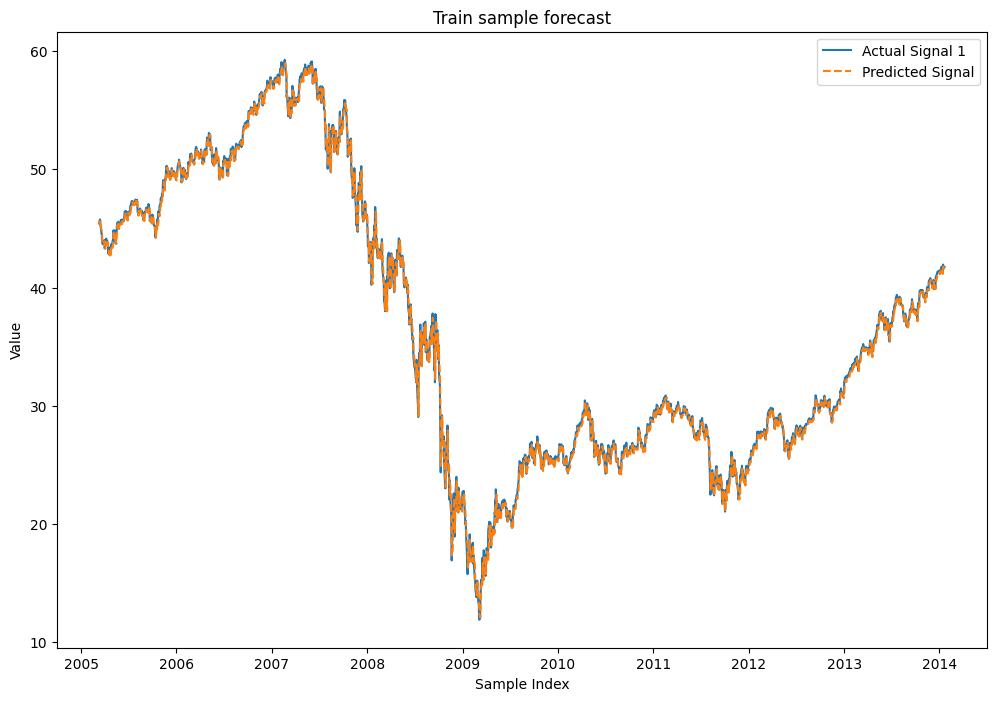

In [ ]:
# Plot train prediction
Y_squeezed = Y_train_np.squeeze()
Y_predicted = Y_predicted_train
plot_results(Y_squeezed, Y_predicted,Y_train.index, 'Train sample forecast', random_color = True)

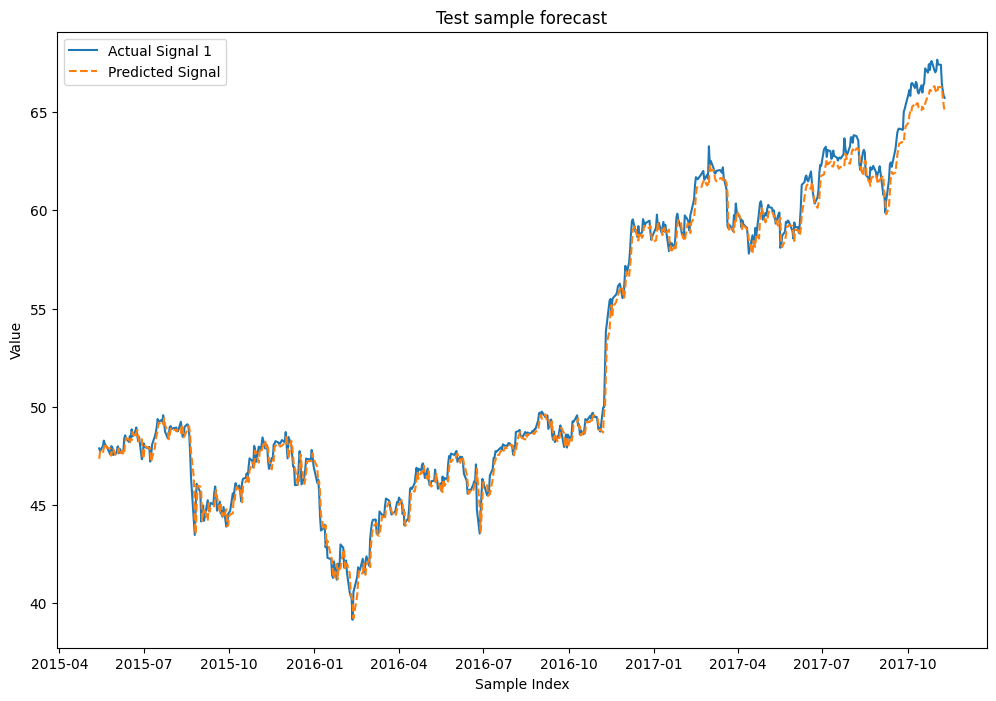

In [ ]:
# Plot test prediction
Y_squeezed = Y_test_np.squeeze()
Y_predicted = Y_predicted_test
plot_results(Y_squeezed, Y_predicted,Y_test.index, 'Test sample forecast')

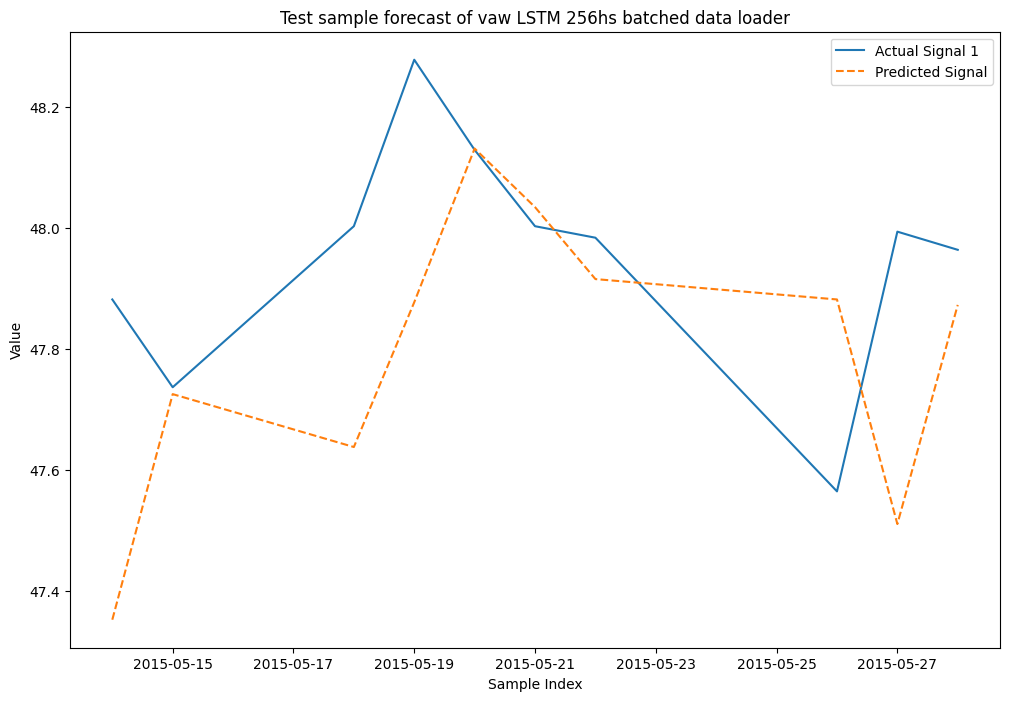

In [ ]:
#Plot first 10 days prediction
if(not multi_stock):
  Y_squeezed = Y_test[:10].squeeze()
  Y_predicted = Y_predicted_test[:10]
  plot_results(Y_squeezed, Y_predicted,Y_test.index[:10] ,'Test sample forecast of the first 10 days')

In [ ]:
#try to see non normalized loss
mse = np.mean((Y_squeezed - Y_predicted) ** 2)
print("Mean Squared Error:", mse) #we are not sure it works on muly as it gave us some weird answers.

Mean Squared Error: 109.43184740169113
